# Import libraries

In [1]:
# for dataframe building
import pandas as pd
import numpy as np
from surprise import Dataset, Reader

# Importing models that I want to run

# To make our data usable for our models
from surprise import Reader, Dataset

# Basic Models
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms.baseline_only import BaselineOnly

# KNN Based Models
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline

# Matrix Factorization Based Models
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp, NMF

# To help measure how our models do
from surprise.model_selection import cross_validate
from surprise.accuracy import rmse

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import data

In [2]:
links = pd.read_csv('Data/links.csv')
tags = pd.read_csv('Data/tags.csv')
ratings = pd.read_csv('Data/ratings.csv')
movies = pd.read_csv('Data/movies.csv')

# merge data into one dataframe

merge ratings and movie info

In [3]:
df = pd.merge(ratings, movies, left_on='movieId', right_on='movieId', how='left')

merge previous set with links

In [4]:
df = pd.merge(df, links, left_on = 'movieId', right_on='movieId', how='left')

Putting our data into the needed format for these models

In [5]:
temp = df[['userId', 'movieId', 'rating']]

#### This will be to get our movie recommendations at the end

In [79]:
def get_movie_recs(movies,user, n_recs):
    '''
    Returns the top n recommendations for movies.
    
    movies: The dataframe with the movie ID numbers and titles.
    
    user: User ID number
    
    n_recs: The number of recommendations to return
    '''
    movie_list = []
    for movie in temp['movieId'].unique():
        movie_list.append((movie,svd_pp.predict(user,movie)[3]))

    ranked_movie_list = sorted(movie_list, key=lambda x:x[1], reverse=True)
    recommendations = []
    for m in ranked_movie_list[0:n_recs]:
        recommendations.append(movies[movies['movieId']==m[0]]['title'])
    print(user)
    return recommendations

## Quick EDA

Since ratings are a key part of how our models will work, I wanted to see a quick distribution of the ratings

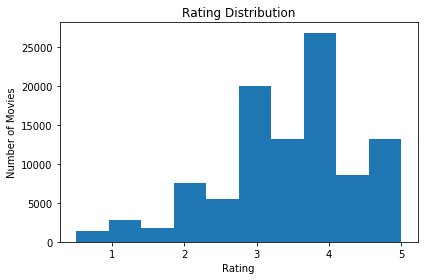

In [83]:
plt.hist(temp.rating)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.savefig('Images/ratingdist.png')

The year for each movie is given at the end as (YYYY) in each title. I run through the titles and extract the year and make sure we have numerical values.

In [7]:
years = []
for title in movies.title:
    years.append(title[-5:-1])

In [16]:
cleaned_years = []
for year in years:
    try:
        cleaned_years.append(int(year))
    except:
        cleaned_years.append(None)

In [17]:
movies['year'] = cleaned_years

In [30]:
my_years = movies.year.dropna()

I wanted to get a quick idea of the years that the movie set spans. One of our next steps will be to see if our model chooses certain years/decades over others and if there is an explanation why.

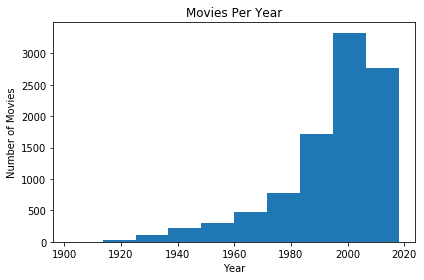

In [82]:
plt.hist(my_years)
plt.title('Movies Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.savefig('Images/movieyear.png')

I am assigning streaming services randomly to each movie. This will do nothing in our model. However, it will help visually with my idea in recommending movies and what streaming platforms they are offered on.

In [38]:
services = ['Amazon Prime', 'Netflix', 'Hulu', 'Disney Plus', 'Other']
movie_services = [np.random.choice(services, p=[.3,.3,.20,.15,.05]) for i in range(9742)]
movies['service'] = movie_services

In [39]:
streaming_services = dict(movies.service.value_counts())

I am looking at the distribution of the streaming service tags that I randomly assigned.

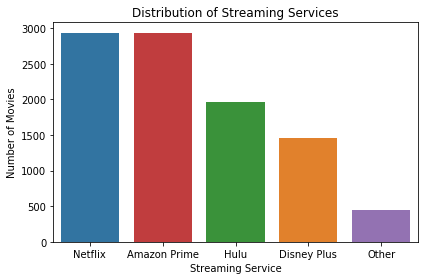

In [81]:
sns.barplot(list(streaming_services.keys()), list(streaming_services.values()), palette=['C0','C3','C2','C1','C4'])
plt.title('Distribution of Streaming Services')
plt.xlabel('Streaming Service')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.savefig('Images/dist_service.png')

# Turn genres into a list
I'm doing this to separate each genre as their own object instead of all of them being together into one string. This will help when I encode genres.

In [41]:
def genre_list(entry):
    return entry.split('|')

In [42]:
df.genres = df.genres.apply(genre_list)

# Going Through Models
I will run models and compare one another as is

Make our data usable for our model

In [43]:
reader = Reader()
data = Dataset.load_from_df(temp, reader)

#### Making an instance of each model

Basic

In [44]:
norm_pred = NormalPredictor()
baseline = BaselineOnly()

KNN Based

In [45]:
knn_basic = KNNBasic()
knn_means = KNNWithMeans()
knn_z = KNNWithZScore()
knn_baseline = KNNBaseline()

Matrix-Factorization Based

In [46]:
svd = SVD()
svd_pp = SVDpp()
nmf = NMF()

##### This will run the data through each model and calculate the average rmse and mae. It will append the scores list with the name of the algorithm, the average rmse, and the average mae


In [47]:
algs = [norm_pred, baseline, knn_basic, knn_means, knn_z, knn_baseline, svd, svd_pp, nmf]
algs_name = ['Normal Predictor', 'Baseline Only', 'KNN Basic', 'KNN with Means', 'KNN with Z-score', 'KNN Baseline', 'SVD', 'SVD pp', 'NMF']
scores = []
for a in algs:
    output = cross_validate(a, data, n_jobs=-1)
    rmse = np.mean(output['test_rmse'])
    mae = np.mean(output['test_mae'])
    scores.append([algs_name[algs.index(a)], rmse, mae])

##### Checking the scores

In [48]:
scores

[['Normal Predictor', 1.421790294040056, 1.1353374941000929],
 ['Baseline Only', 0.8725156067406484, 0.6726875150509878],
 ['KNN Basic', 0.9467594139423179, 0.7253505980356161],
 ['KNN with Means', 0.8962132182696518, 0.6845415117398332],
 ['KNN with Z-score', 0.8943579951002167, 0.6787622410625431],
 ['KNN Baseline', 0.873053202343454, 0.6675069694492348],
 ['SVD', 0.8732820832018253, 0.671015518433947],
 ['SVD pp', 0.8609917633484961, 0.6597793802262766],
 ['NMF', 0.9224528298044357, 0.7066733849732096]]

# SVDpp did the best, so we continue to build our recommendation system with this model

#### Picking a random user and looking at their movie selections

In [49]:
user = np.random.choice(df.userId)
print(user)

552


In [50]:
user_ratings = df[df.userId == user]
user_ratings = user_ratings[['userId', 'movieId', 'rating']]

In [51]:
for m in user_ratings.sort_values('rating',ascending=False).movieId[:10]:
    print(movies[movies['movieId']==m].title)

1883    Office Space (1999)
Name: title, dtype: object
4800    Lord of the Rings: The Return of the King, The...
Name: title, dtype: object
898    Star Wars: Episode V - The Empire Strikes Back...
Name: title, dtype: object
863    Monty Python and the Holy Grail (1975)
Name: title, dtype: object
3562    Donnie Darko (2001)
Name: title, dtype: object
4046    Gallipoli (1981)
Name: title, dtype: object
474    Blade Runner (1982)
Name: title, dtype: object
2536    Muppet Movie, The (1979)
Name: title, dtype: object
1218    L.A. Confidential (1997)
Name: title, dtype: object
815    Willy Wonka & the Chocolate Factory (1971)
Name: title, dtype: object


In [52]:
for m in user_ratings.movieId[0:10]:
    print(movies[movies.movieId==m].title, movies[movies.movieId==m].genres)

2    Grumpier Old Men (1995)
Name: title, dtype: object 2    Comedy|Romance
Name: genres, dtype: object
18    Ace Ventura: When Nature Calls (1995)
Name: title, dtype: object 18    Comedy
Name: genres, dtype: object
24    Leaving Las Vegas (1995)
Name: title, dtype: object 24    Drama|Romance
Name: genres, dtype: object
84    Broken Arrow (1996)
Name: title, dtype: object 84    Action|Adventure|Thriller
Name: genres, dtype: object
92    Happy Gilmore (1996)
Name: title, dtype: object 92    Comedy
Name: genres, dtype: object
134    Crimson Tide (1995)
Name: title, dtype: object 134    Drama|Thriller|War
Name: genres, dtype: object
145    Judge Dredd (1995)
Name: title, dtype: object 145    Action|Crime|Sci-Fi
Name: genres, dtype: object
201    Ed Wood (1994)
Name: title, dtype: object 201    Comedy|Drama
Name: genres, dtype: object
257    Pulp Fiction (1994)
Name: title, dtype: object 257    Comedy|Crime|Drama|Thriller
Name: genres, dtype: object
276    Santa Clause, The (1994)
Name: ti

#### Using SVDpp to make predictions

In [53]:
svd_pp = SVDpp(n_factors=50, reg_all=0.05)

Making a train set and test set. Then we fit our model to our train set

In [54]:
train_set = data.build_full_trainset()

In [55]:
svd_pp.fit(train_set)

In [56]:
test_set = train_set.build_anti_testset()
predictions = svd_pp.test(test_set)

# Getting movie recommendations for our user

In [80]:
get_movie_recs(movies, user, 10)

552


[257    Pulp Fiction (1994)
 Name: title, dtype: object, 659    Godfather, The (1972)
 Name: title, dtype: object, 898    Star Wars: Episode V - The Empire Strikes Back...
 Name: title, dtype: object, 224    Star Wars: Episode IV - A New Hope (1977)
 Name: title, dtype: object, 863    Monty Python and the Holy Grail (1975)
 Name: title, dtype: object, 461    Schindler's List (1993)
 Name: title, dtype: object, 922    Godfather: Part II, The (1974)
 Name: title, dtype: object, 602    Dr. Strangelove or: How I Learned to Stop Worr...
 Name: title, dtype: object, 277    Shawshank Redemption, The (1994)
 Name: title, dtype: object, 474    Blade Runner (1982)
 Name: title, dtype: object]